# Module 3 - Dataset Design & Feature Engineering for "SecureBank" Fraud Detection System
# Exploratory Data Analysis
by Jose Márquez Jaramillo (jmarqu20)

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
transactions = pd.read_csv('../data/transactions_0.csv')
# Assuming 'transactions' is your DataFrame
# Convert 'trans_date_trans_time' to datetime
transactions['trans_date_trans_time'] = pd.to_datetime(transactions['trans_date_trans_time'])
transactions['day_of_week'] = transactions['trans_date_trans_time'].dt.day_name()
transactions['month'] = transactions['trans_date_trans_time'].dt.month_name()

## Question 1: What is the distribution between fraudulent and non-fraudulent transactions?

In [3]:
fraud_counts = transactions['is_fraud'].value_counts().reset_index()
print('Distribution of Fraudulent Transactions')
fraud_counts['is_fraud_percent'] = fraud_counts['is_fraud']/ transactions['is_fraud'].count()
fraud_counts

Distribution of Fraudulent Transactions


,index,is_fraud,is_fraud_percent
0,0.0,331369,0.993262
1,1.0,2248,0.006738


From the transactions_0 dataset, we can observe that 331,369 (99.3262%) of the transactions are non-fraudulent while 2,248 (0.6738%) of transactions are fraudulent.

## Question 2: Which age groups are more susceptible to fraudulent transactions?

In [4]:
# convert the dob into datetime
transactions['dob'] = pd.to_datetime(transactions['dob'])

In [5]:
# generate a customer level table
customer = transactions[['cc_num','first','last','sex','street','city','state','zip','lat','long','job','dob']]
customer = customer.drop_duplicates(subset='cc_num', keep='first')

In [6]:
customer['year_of_birth'] = customer['dob'].dt.year

In [7]:
# we will define age-groups based on generations, for more information please refer to
    # https://libguides.usc.edu/busdem/age
cond = [customer['year_of_birth']>=2013,
        customer['year_of_birth']>=1995,
        customer['year_of_birth']>=1980,
        customer['year_of_birth']>=1965,
        customer['year_of_birth']>=1946,
        customer['year_of_birth']>=1925,
        customer['year_of_birth']>=1901]
groups = ['Alpha',
          'Z',
          'Millennial',
          'X',
          'Baby Boomer',
          'Silent',
          'Greatest']
customer['age_group'] = np.select(cond, groups)
# define the age by the number of years from birth to now
customer['age_years'] = (pd.Timestamp.now() - customer['dob']) / np.timedelta64(1, 'Y')

In [8]:
# Check whether a customer has been victim of a fraudulent transaction during the period
fraud_victims = transactions[transactions['is_fraud'] == 1]['cc_num'].unique()
# mark those which have been shown to be victims of fraud
customer['fraud_victim'] = customer['cc_num'].isin(fraud_victims)

In [9]:
# create a Pivot Table counting
pivot = customer.pivot_table(index='age_group', columns='fraud_victim', values='cc_num', aggfunc='count', fill_value=0,margins=True)
# Sort by the total number of clients
pivot.sort_values(by='All', ascending=False, inplace=True)
pivot

fraud_victim,False,True,All
age_group,,,
All,686,250,936
Millennial,179,62,241
X,186,55,241
Baby Boomer,152,56,208
0,69,25,94
Silent,63,27,90
Z,36,25,61
Greatest,1,0,1


<AxesSubplot:title={'center':'Proportion of Fraud Victims within Age Group'}, xlabel='age_group'>

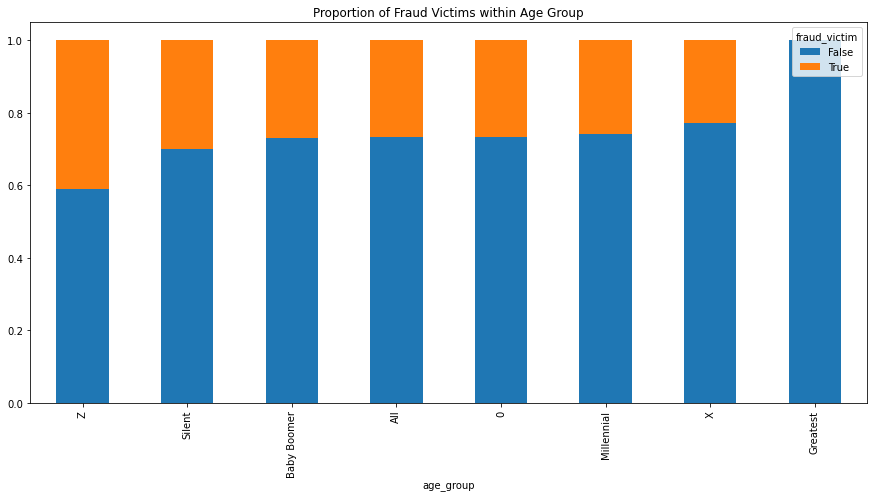

In [10]:
# compute the proportion based on the row total, or the percentage within the groups
for col in pivot.columns:
    pivot[col] /= pivot['All']
# Drop the row total
pivot.drop('All', axis=1, inplace=True)
# Sort by those with a higher proportion within group
pivot.sort_values(by=True,ascending=False,inplace=True)
# plot the graph into a bar chart
pivot.plot(kind='bar', stacked=True, title='Proportion of Fraud Victims within Age Group', figsize = (15,7))

In [11]:
pivot

fraud_victim,False,True
age_group,,
Z,0.590164,0.409836
Silent,0.700000,0.300000
Baby Boomer,0.730769,0.269231
All,0.732906,0.267094
0,0.734043,0.265957
Millennial,0.742739,0.257261
X,0.771784,0.228216
Greatest,1.000000,0.000000


From the table and charts above, we observe that the overall proportion of fraudulent clients is 26.71%. Although the total number of fraudulent clients is higher in the Millennial and X age groups (62 and 55 respectively), the proportions within these age groups vary significantly. This variation may result from the population being skewed towards the Millennial and X age groups. When examining the proportions of customers who are fraud victims within each age group, the Z and Silent age groups show higher fraud victim rates, with 41% and 30% respectively, compared to 25.7% and 22.8% for the Millennial and X age groups.

## Question 4: For each purchase "category," plot the mean and standard "amt" between fraudulent transactions and non-fraudulent transactions

In [12]:
# normalize transaction categories by making them all upper case
transactions['category'] = transactions['category'].str.upper()
# create a pivot table summarizing the mean and standard deviations of transactions based on wether
# they are fraudulent or not
pivot = transactions.groupby(['category','is_fraud'])['amt'].agg(['mean','std'])
pivot.sort_index(ascending=False, inplace=True)

In [13]:
pivot.reset_index(inplace=True)
pivot['color'] = pivot['is_fraud'].map({0:'b', 1:'r'})

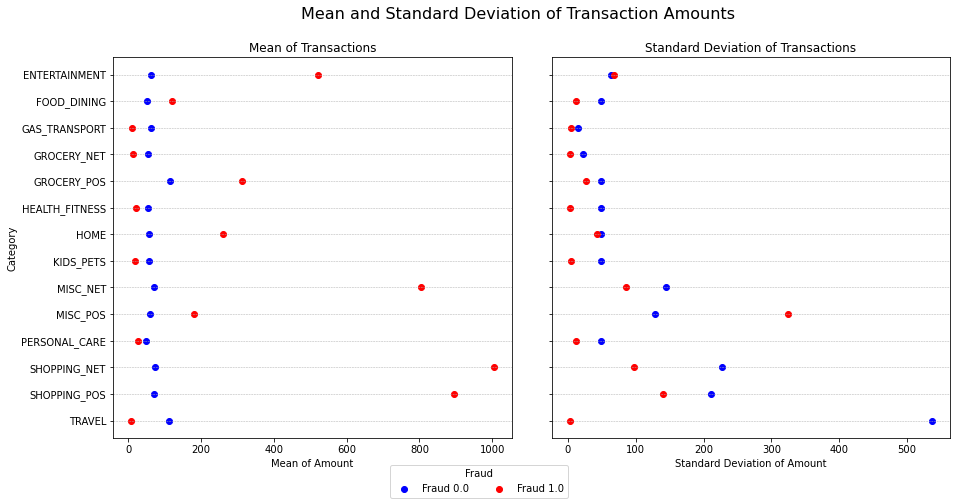

In [14]:
# Create a figure and subplots
fig = plt.figure(figsize=(15, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)  # Adjust wspace for less space between subplots

ax1 = fig.add_subplot(gs[0, 0])  # This is the first subplot
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)  # This is the second subplot, sharing the y-axis with the first

# Plot the scatter plots
for label, df in pivot.groupby('is_fraud'):
    ax1.scatter(df['mean'], df['category'], label=f'Fraud {label}', color=df['color'].iloc[0])
    ax2.scatter(df['std'], df['category'], label=f'Fraud {label}', color=df['color'].iloc[0])

# Customize the first subplot
ax1.set_title('Mean of Transactions')
ax1.set_xlabel('Mean of Amount')
ax1.set_ylabel('Category')
ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Customize the second subplot
ax2.set_title('Standard Deviation of Transactions')
ax2.set_xlabel('Standard Deviation of Amount')
ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Hide y-axis labels for the second subplot to avoid redundancy
plt.setp(ax2.get_yticklabels(), visible=False)

# Add a single legend at the bottom
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, title='Fraud')
fig.suptitle("Mean and Standard Deviation of Transaction Amounts", fontsize=16)

# Adjust layout
#plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust the layout to make room for the legend

# Show the plot
plt.show()

## Question 5:What is the distribution between time transactions between fraudulent transactions and non-fraudulent transactions? What is the most likely time of a fraudulent transaction?

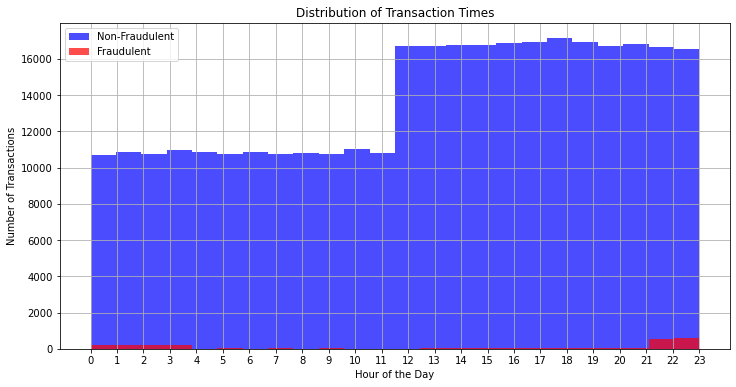

The most likely time for a fraudulent transaction is around: 23 o'clock.


In [15]:
transactions['time'] = transactions['trans_date_trans_time'].dt.time
transactions['hour'] = transactions['trans_date_trans_time'].dt.hour

# Filter data for fraudulent and non-fraudulent transactions
fraud_transactions = transactions[transactions['is_fraud'] == 1]
non_fraud_transactions = transactions[transactions['is_fraud'] == 0]

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(non_fraud_transactions['hour'], bins=24, alpha=0.7, label='Non-Fraudulent', color='blue')
plt.hist(fraud_transactions['hour'], bins=24, alpha=0.7, label='Fraudulent', color='red')
plt.title('Distribution of Transaction Times')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Transactions')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.show()

most_frequent_hour = fraud_transactions['hour'].mode()[0]
print("The most likely time for a fraudulent transaction is around:", most_frequent_hour, "o'clock.")

From the chart, we observe that non-fraudulent transactions occur frequently and uniformly throughout the day with a slight decrease during the early hours (midnight to early morning). Conversely, fraudulent transactions are relatively sparse and show a distinct peak during the late night and early morning hours.
The most notable insight from this visualization is that fraudulent transactions tend to occur predominantly in the early morning hours, specifically around the time period that appears to be around 2 AM to 4 AM. This could indicate that fraudsters prefer times when vigilance may be lower, or fewer transactions overall make fraudulent activities less conspicuous to detect by automated systems.

## Question 8: What is the distribution of fraudulent and non-fraudulent transactions occurring for each day of the week (i.e., Sunday, Monday, etc.), each month of the year (i.e., January, February)?

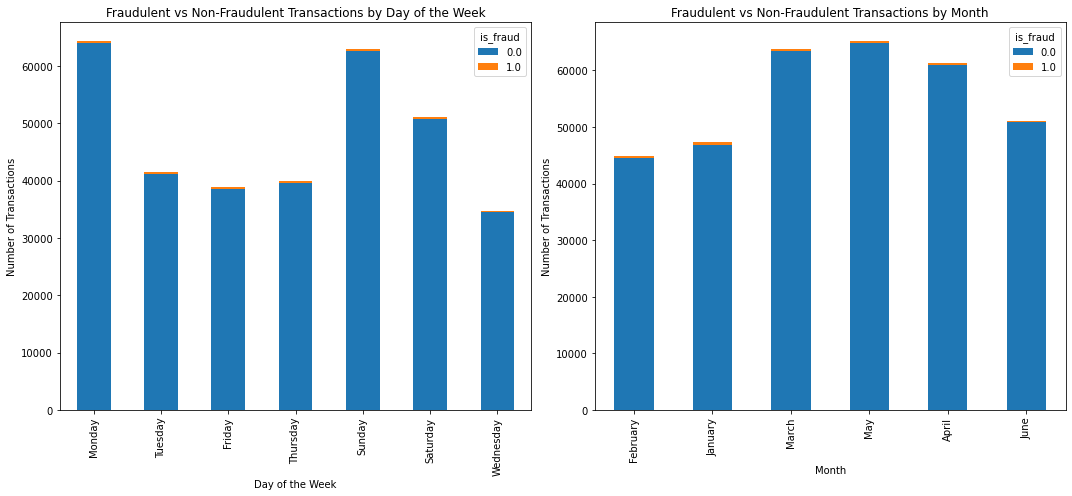

Transactions by Day of the Week:
is_fraud       0.0  1.0
day_of_week            
Monday       63972  407
Tuesday      41232  349
Friday       38564  335
Thursday     39655  307
Sunday       62666  298
Saturday     50791  282
Wednesday    34489  270

Transactions by Month:
is_fraud    0.0  1.0
month               
February  44436  460
January   46884  454
March     63394  439
May       64846  375
April     60881  340
June      50928  180


In [16]:
# Setup the figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(15,7))  # 1 row, 2 columns

# First subplot: Fraudulent vs Non-Fraudulent Transactions by Day of the Week
pivot_day = transactions.pivot_table(index='day_of_week', columns='is_fraud',
                                     values='trans_num', aggfunc='nunique',
                                     margins=True)
pivot_day['percent'] = pivot_day[1.0]/pivot_day['All']
pivot_day.sort_values(by=1.0, inplace=True, ascending=False)
pivot_day.drop(['percent', 'All'], axis=1, inplace=True)
pivot_day.drop('All', axis=0, inplace=True)
pivot_day.plot(kind='bar', stacked=True, ax=ax[0])
ax[0].set_title('Fraudulent vs Non-Fraudulent Transactions by Day of the Week')
ax[0].set_xlabel('Day of the Week')
ax[0].set_ylabel('Number of Transactions')

# Second subplot: Fraudulent vs Non-Fraudulent Transactions by Month
pivot_month = transactions.pivot_table(index='month', columns='is_fraud',
                                       values='trans_num', aggfunc='nunique',
                                       margins=True)
pivot_month['percent'] = pivot_month[1.0]/pivot_month['All']
pivot_month.sort_values(by=1.0, inplace=True, ascending=False)
pivot_month.drop(['percent', 'All'], axis=1, inplace=True)
pivot_month.drop('All', axis=0, inplace=True)
pivot_month.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Fraudulent vs Non-Fraudulent Transactions by Month')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Number of Transactions')

# Show the entire plot
plt.tight_layout()
plt.show()

# Optionally print the pivot tables for detailed numbers
print("Transactions by Day of the Week:")
print(pivot_day)
print("\nTransactions by Month:")
print(pivot_month)

The provided bar charts reveal the distribution of fraudulent and non-fraudulent transactions across different days of the week and months of the year. The first chart shows a fairly consistent pattern of fraudulent transactions throughout the week, with slightly higher occurrences on Fridays, suggesting a minor peak in fraudulent activities as the week ends. Non-fraudulent transactions appear uniformly distributed across all days, with a noticeable dip on Sundays. In the second chart, non-fraudulent transactions display consistent levels throughout the year, while fraudulent transactions exhibit a slight peak during March and a notable spike in August, indicating seasonal variations in fraudulent activities. This information suggests that fraud monitoring systems could benefit from increased vigilance during these specific times.

# Question 11: Are certain "jobs" susceptible to fraudulent transactions?

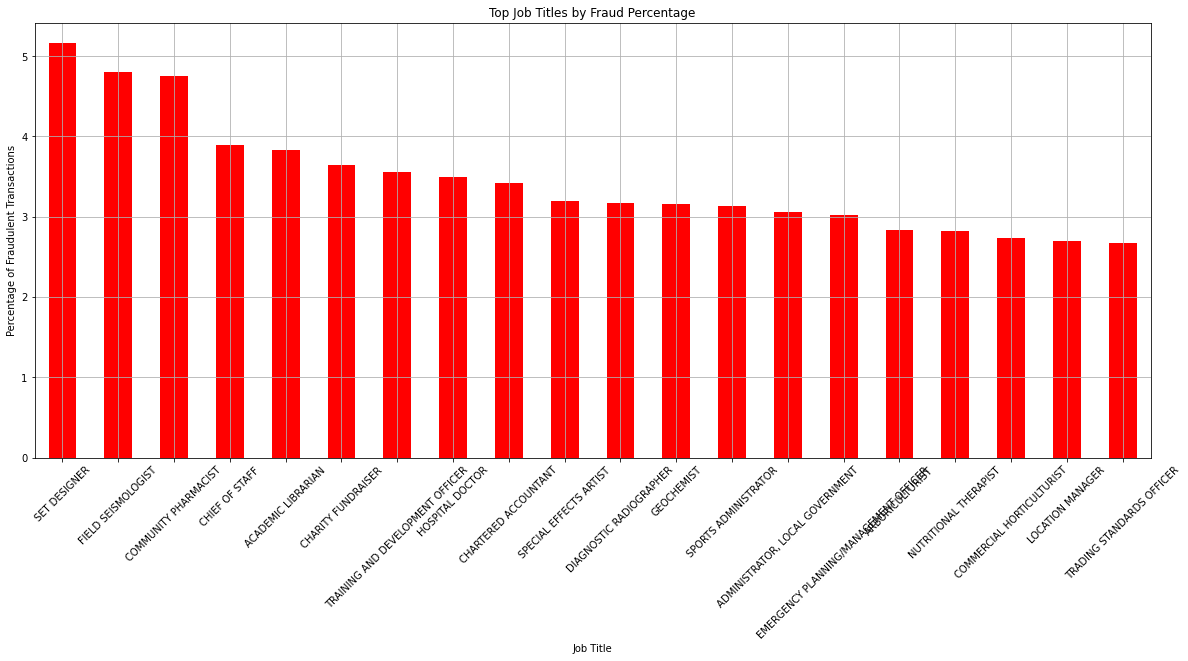

In [17]:
transactions['job'] = transactions['job'].str.upper()
# Grouping the data by 'job' and 'is_fraud' and counting the occurrences
job_fraud_counts = transactions.groupby(['job', 'is_fraud']).size().unstack(fill_value=0)

# Adding a column to calculate the percentage of fraudulent transactions per job
job_fraud_counts['total_transactions'] = job_fraud_counts.sum(axis=1)
job_fraud_counts['fraud_percentage'] = job_fraud_counts[1] / job_fraud_counts['total_transactions'] * 100

# Sorting the DataFrame by the percentage of fraudulent transactions to see the jobs with the highest rates
sorted_jobs = job_fraud_counts.sort_values(by='fraud_percentage', ascending=False)

# Filter out jobs with very few total transactions to avoid statistical anomalies
threshold = 250
significant_jobs = sorted_jobs[sorted_jobs['total_transactions'] > threshold]  # Define a threshold that makes sense for your dataset

# Selecting top N jobs to visualize
top_jobs = significant_jobs.head(20)  # You can adjust the number

# Creating a bar chart
plt.figure(figsize=(20, 8))
top_jobs['fraud_percentage'].plot(kind='bar', color='red')
plt.title('Top Job Titles by Fraud Percentage')
plt.xlabel('Job Title')
plt.ylabel('Percentage of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Althought there is a certain high percentage of fraudulent transactions in Set Designers, Field Seismologists, and Community Pharamcists, there is a certain level of uniformity accross the other job categories. This uniformity suggests that while certain job titles may experience marginally higher fraud occurrences, there is no clear or dramatic distinction that would suggest a specific job title is vastly more susceptible to fraud than others. It's important for further analysis to include additional variables such as transaction volume or value per job title, which might provide more context to these observations and help in understanding if certain professions are indeed at higher risk or if the data simply reflects a broader occupational distribution of card usage.